# Setup e carregamento

In [13]:
# CÉLULA 1: SETUP E CARREGAMENTO
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, sum, desc, when, expr, avg
from pyspark.sql.types import StringType
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np

# Inicializar Spark Session
spark = SparkSession.builder.appName("PNAD_COVID_Final_Analysis").getOrCreate()

# Carregar os arquivos (Verifique se os nomes batem com seus arquivos)
try:
    df05 = spark.read.csv("052020.csv", header=True, inferSchema=True)
    df06 = spark.read.csv("062020.csv", header=True, inferSchema=True)
    df07 = spark.read.csv("072020.csv", header=True, inferSchema=True)
    print("Arquivos carregados com sucesso!")
except Exception as e:
    print(f"Erro ao carregar CSVs: {e}")

Arquivos carregados com sucesso!


# Unificação e Tratamento de Schema

In [14]:
# CÉLULA 2: UNIFICAÇÃO DOS DADOS
# Definição das listas de colunas (Baseado nos erros anteriores)
cols_114 = [
    'Ano', 'UF', 'CAPITAL', 'RM_RIDE', 'V1008', 'V1012', 'V1013', 'V1016', 'Estrato', 'UPA', 'V1022', 'V1023', 'V1030',
    'V1031', 'V1032', 'posest', 'A001', 'A001A', 'A001B1', 'A001B2', 'A001B3', 'A002', 'A003', 'A004', 'A005', 'B0011',
    'B0012', 'B0013', 'B0014', 'B0015', 'B0016', 'B0017', 'B0018', 'B0019', 'B00110', 'B00111', 'B00112', 'B002',
    'B0031', 'B0032', 'B0033', 'B0034', 'B0035', 'B0036', 'B0037', 'B0041', 'B0042', 'B0043', 'B0044', 'B0045',
    'B0046', 'B005', 'B006', 'B007', 'C001', 'C002', 'C003', 'C004', 'C005', 'C0051', 'C0052', 'C0053', 'C006',
    'C007', 'C007A', 'C007B', 'C007C', 'C007D', 'C007E', 'C007E1', 'C007E2', 'C008', 'C009', 'C010', 'C0101',
    'C01011', 'C01012', 'C0102', 'C01021', 'C01022', 'C0103', 'C0104', 'C011A', 'C011A1', 'C011A11', 'C011A12',
    'C011A2', 'C011A21', 'C011A22', 'C012', 'C013', 'C014', 'C015', 'C016', 'C017A', 'D0011', 'D0013', 'D0021',
    'D0023', 'D0031', 'D0033', 'D0041', 'D0043', 'D0051', 'D0053', 'D0061', 'D0063', 'D0071', 'D0073', 'F001',
    'F0021', 'F0022', 'F0061', 'F006'
]

cols_145 = [
    'Ano', 'UF', 'CAPITAL', 'RM_RIDE', 'V1008', 'V1012', 'V1013', 'V1016', 'Estrato', 'UPA', 'V1022', 'V1023', 'V1030',
    'V1031', 'V1032', 'posest', 'A001', 'A001A', 'A001B1', 'A001B2', 'A001B3', 'A002', 'A003', 'A004', 'A005', 'A006',
    'A007', 'A008', 'A009', 'B0011', 'B0012', 'B0013', 'B0014', 'B0015', 'B0016', 'B0017', 'B0018', 'B0019', 'B00110',
    'B00111', 'B00112', 'B00113', 'B002', 'B0031', 'B0032', 'B0033', 'B0034', 'B0035', 'B0036', 'B0037', 'B0041',
    'B0042', 'B0043', 'B0044', 'B0045', 'B0046', 'B005', 'B006', 'B007', 'B008', 'B009A', 'B009B', 'B009C', 'B009D',
    'B009E', 'B009F', 'B0101', 'B0102', 'B0103', 'B0104', 'B0105', 'B0106', 'B011', 'C001', 'C002', 'C003', 'C004',
    'C005', 'C0051', 'C0052', 'C0053', 'C006', 'C007', 'C007A', 'C007B', 'C007C', 'C007D', 'C007E', 'C007E1', 'C007E2',
    'C007F', 'C008', 'C009', 'C009A', 'C010', 'C0101', 'C01011', 'C01012', 'C0102', 'C01021', 'C01022', 'C0103',
    'C0104', 'C011A', 'C011A1', 'C011A11', 'C011A12', 'C011A2', 'C011A21', 'C011A22', 'C012', 'C013', 'C014', 'C015',
    'C016', 'C017A', 'D0011', 'D0013', 'D0021', 'D0023', 'D0031', 'D0033', 'D0041', 'D0043', 'D0051', 'D0053', 'D0061',
    'D0063', 'D0071', 'D0073', 'E001', 'E0021', 'E0022', 'E0023', 'E0024', 'F001', 'F0021', 'F0022', 'F002A1',
    'F002A2', 'F002A3', 'F002A4', 'F002A5', 'F0061', 'F006'
]

# Função para padronizar e adicionar mês
def prepare_df(df, month_label, cols_order):
    # Seleciona apenas colunas que existem no DF atual para evitar erro
    common_cols = [c for c in cols_order if c in df.columns]
    df = df.select(*common_cols)

    # Adiciona colunas faltantes do superset como NULL
    for c in cols_145:
        if c not in df.columns:
            df = df.withColumn(c, lit(None))

    # Adiciona Mês e Ordena
    df = df.withColumn("MES", lit(month_label)).select(*cols_145, "MES")
    return df

# Aplicar e Unir
print("Unificando DataFrames...")
df05_ready = prepare_df(df05, "05/2020", cols_114)
df06_ready = prepare_df(df06, "06/2020", cols_114)
df07_ready = prepare_df(df07, "07/2020", cols_145)

df_final = df05_ready.unionByName(df06_ready).unionByName(df07_ready)
print(f"Unificação Concluída! Total de linhas: {df_final.count()}")

Unificando DataFrames...
Unificação Concluída! Total de linhas: 1114742


In [16]:
print(df_final)

DataFrame[Ano: int, UF: int, CAPITAL: int, RM_RIDE: int, V1008: int, V1012: int, V1013: int, V1016: int, Estrato: int, UPA: int, V1022: int, V1023: int, V1030: int, V1031: double, V1032: double, posest: int, A001: int, A001A: int, A001B1: int, A001B2: int, A001B3: int, A002: int, A003: int, A004: int, A005: int, A006: int, A007: int, A008: int, A009: int, B0011: int, B0012: int, B0013: int, B0014: int, B0015: int, B0016: int, B0017: int, B0018: int, B0019: int, B00110: int, B00111: int, B00112: int, B00113: int, B002: int, B0031: int, B0032: int, B0033: int, B0034: int, B0035: int, B0036: int, B0037: int, B0041: int, B0042: int, B0043: int, B0044: int, B0045: int, B0046: int, B005: int, B006: int, B007: int, B008: int, B009A: int, B009B: int, B009C: int, B009D: int, B009E: int, B009F: int, B0101: int, B0102: int, B0103: int, B0104: int, B0105: int, B0106: int, B011: int, C001: int, C002: int, C003: int, C004: int, C005: int, C0051: int, C0052: int, C0053: int, C006: int, C007: int, C00

# População por UF (Análise Mensal)

/tmp/ipython-input-2402468582.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-2402468582.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-2402468582.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


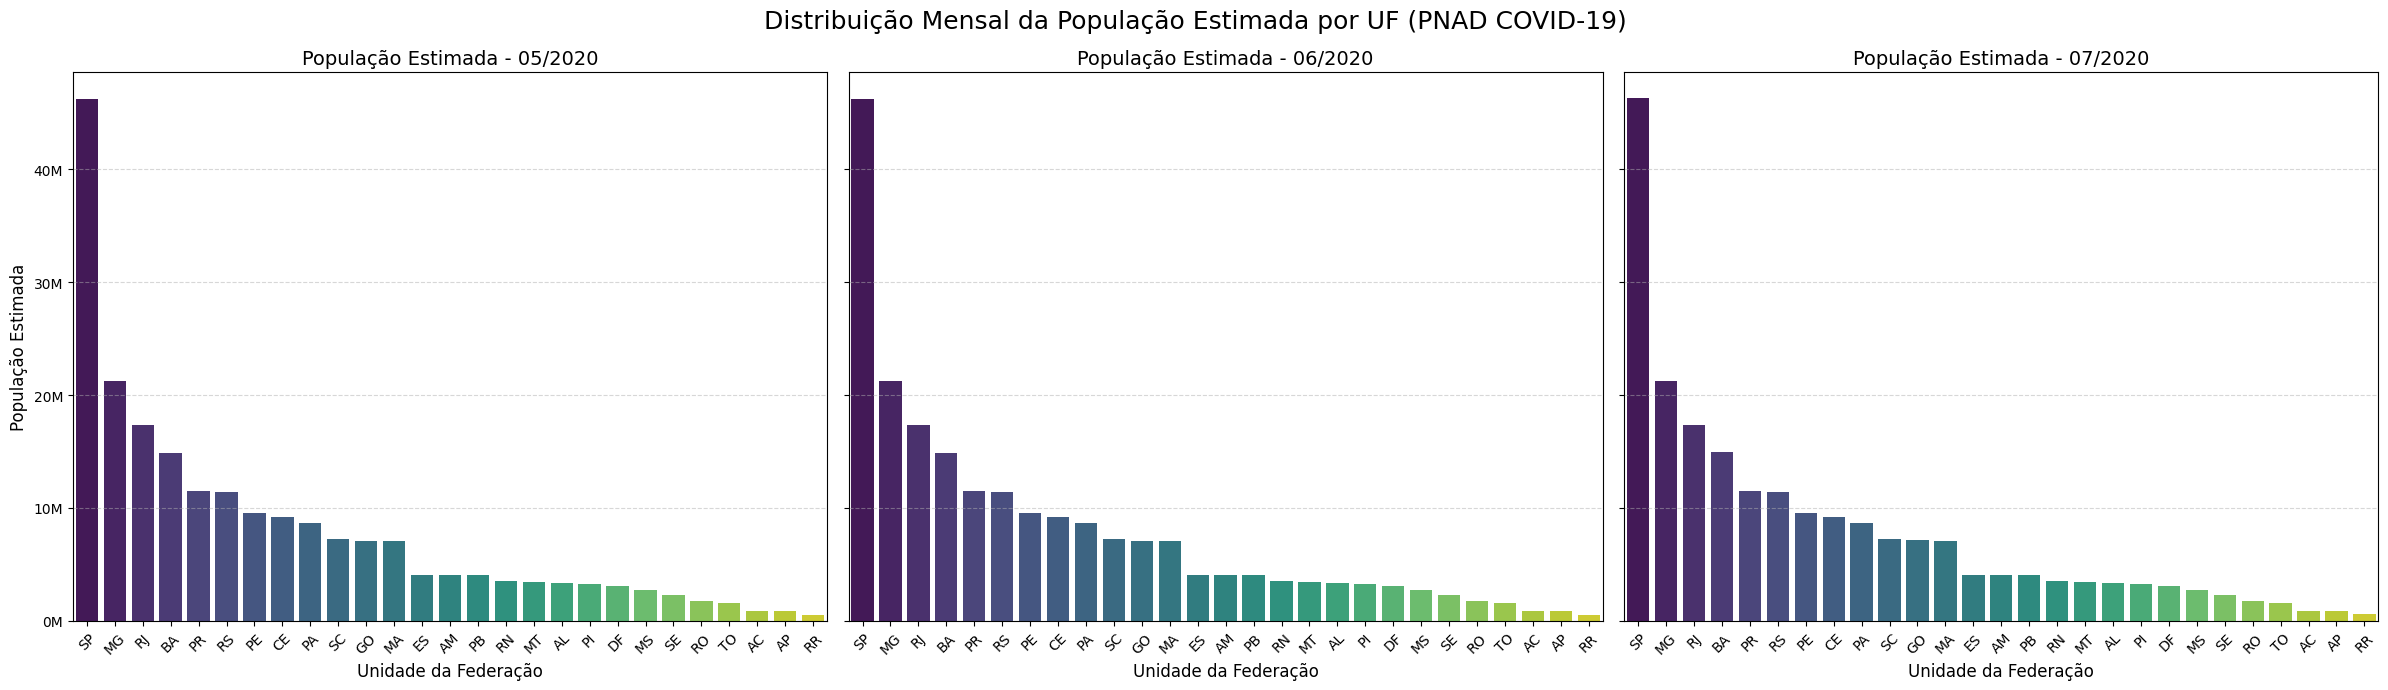

In [18]:
# POPULAÇÃO POR UF (Análise Mensal)
map_uf = {
    11:'RO', 12:'AC', 13:'AM', 14:'RR', 15:'PA', 16:'AP', 17:'TO',
    21:'MA', 22:'PI', 23:'CE', 24:'RN', 25:'PB', 26:'PE', 27:'AL', 28:'SE', 29:'BA',
    31:'MG', 32:'ES', 33:'RJ', 35:'SP', 41:'PR', 42:'SC', 43:'RS',
    50:'MS', 51:'MT', 52:'GO', 53:'DF'
}

# 1. Agregação por MES e UF (Adicionado "MES" no groupBy)
df_uf_mensal = df_final.groupBy("MES", "UF").agg(
    sum(col("V1032")).alias("Populacao")
).toPandas()

# Mapeamento e Ordenação
df_uf_mensal['UF_Sigla'] = df_uf_mensal['UF'].map(map_uf)
# Ordena por Mês e depois por População (Decrescente) para o gráfico ficar bonito
df_uf_mensal = df_uf_mensal.sort_values(by=['MES', 'Populacao'], ascending=[True, False])

# 2. PLOTAGEM (3 Subplots lado a lado)
meses_unicos = sorted(df_uf_mensal['MES'].unique()) # Garante ordem 05, 06, 07
fig, axes = plt.subplots(1, 3, figsize=(24, 7), sharey=True) # sharey=True facilita comparação

for i, mes in enumerate(meses_unicos):
    # Filtrar dados do mês
    data_plot = df_uf_mensal[df_uf_mensal['MES'] == mes]

    # Criar Barplot no eixo correspondente (ax=axes[i])
    sns.barplot(
        x='UF_Sigla',
        y='Populacao',
        data=data_plot,
        ax=axes[i],
        palette='viridis'
    )

    # Configurações do Subplot
    axes[i].set_title(f'População Estimada - {mes}', fontsize=14)
    axes[i].set_xlabel('Unidade da Federação', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)

    # Rótulo Y apenas no primeiro gráfico para limpar o visual
    if i == 0:
        axes[i].set_ylabel('População Estimada', fontsize=12)
        # Formatação do Eixo Y em Milhões (opcional, para ficar mais legível)
        axes[i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:,.0f}M'))
    else:
        axes[i].set_ylabel('')

plt.suptitle('Distribuição Mensal da População Estimada por UF (PNAD COVID-19)', fontsize=18)
plt.tight_layout()
plt.show()

/tmp/ipython-input-2919774763.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_piramide = df_idade_sexo.groupby(['Faixa_Etaria', 'A003'])['Populacao'].sum().unstack(fill_value=0)
/tmp/ipython-input-2919774763.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{abs(t)/1e6:.1f}M' for t in ticks])


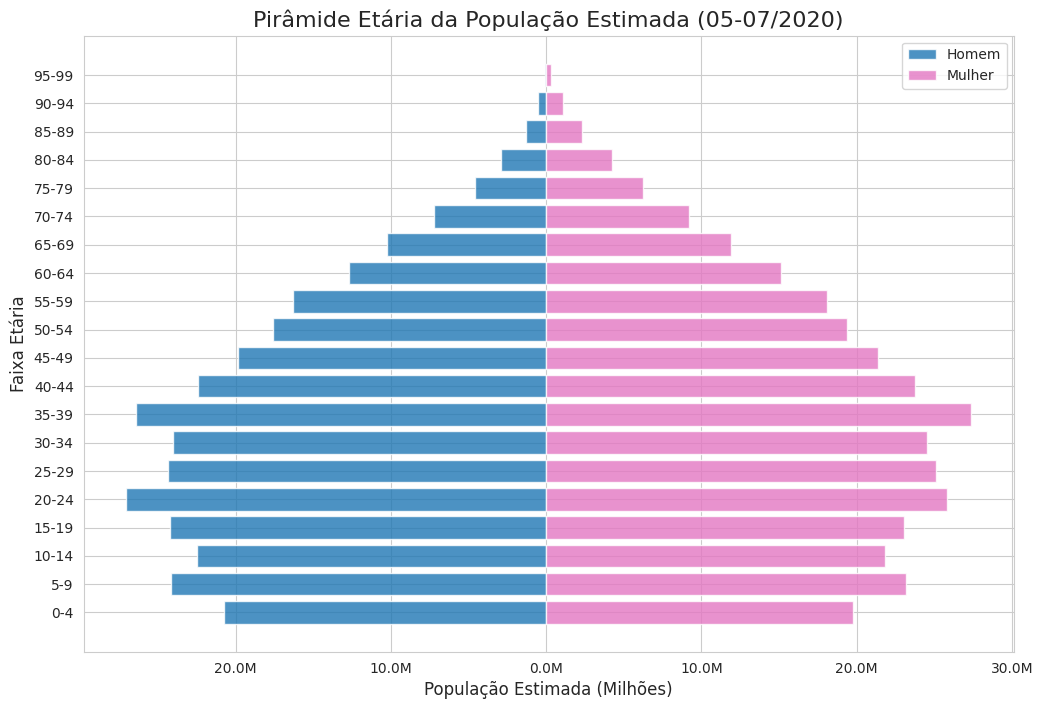

/tmp/ipython-input-2919774763.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Raça_Label', y='Populacao', data=df_raca_plot, palette='viridis')


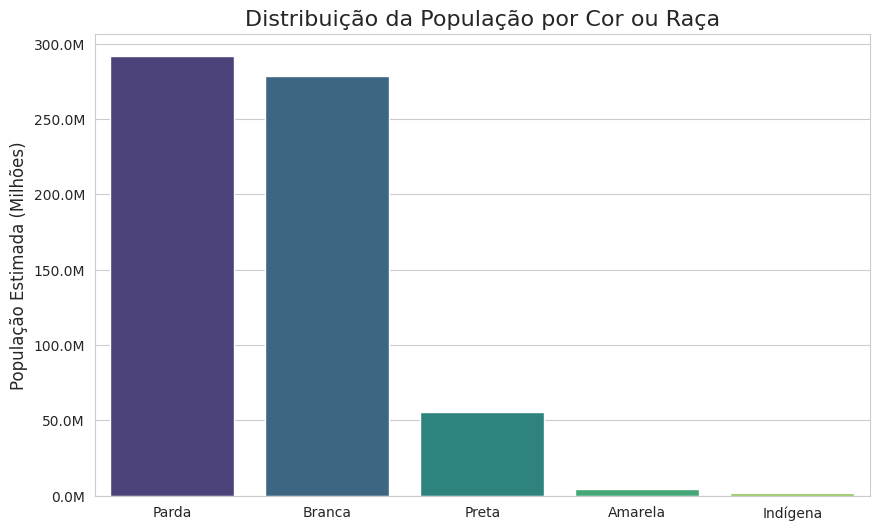

/tmp/ipython-input-2919774763.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Escolaridade_Label', y='Populacao', data=df_escolaridade_plot, palette='magma')


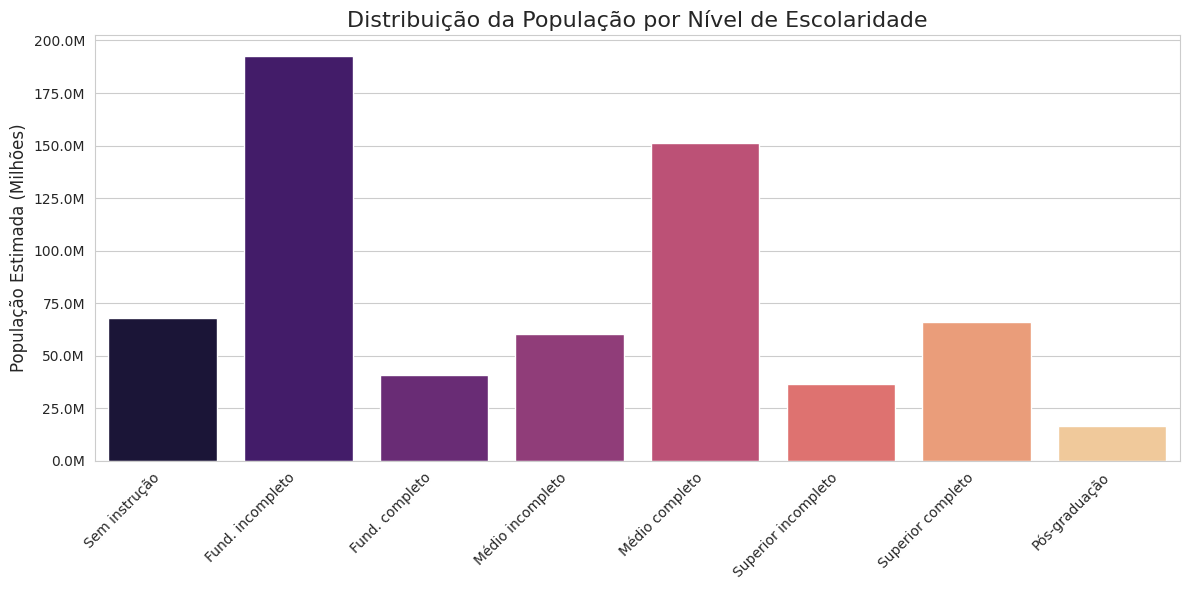

In [19]:
# CÉLULA: EDA - DEMOGRAFIA COMPLETA
from pyspark.sql.functions import sum, col, desc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np

# Mapeamentos (Conforme Dicionário PNAD)
map_sexo = {1: 'Homem', 2: 'Mulher'}
map_raca = {1: 'Branca', 2: 'Preta', 3: 'Amarela', 4: 'Parda', 5: 'Indígena', 9: 'Ignorado'}
map_escolaridade = {
    1: 'Sem instrução',
    2: 'Fund. incompleto',
    3: 'Fund. completo',
    4: 'Médio incompleto',
    5: 'Médio completo',
    6: 'Superior incompleto',
    7: 'Superior completo',
    8: 'Pós-graduação' # Algumas bases podem ter esse código extra
}

# --- 1. AGREGAÇÃO DE DADOS (PySpark) ---

# A. Idade (A002) e Sexo (A003)
df_idade_sexo = df_final.groupBy("A002", "A003").agg(
    sum(col("V1032")).alias("Populacao")
).toPandas()

# B. Cor/Raça (A004)
df_raca = df_final.groupBy("A004").agg(
    sum(col("V1032")).alias("Populacao")
).orderBy(desc("Populacao")).toPandas()

# C. Escolaridade (A005)
df_escolaridade = df_final.groupBy("A005").agg(
    sum(col("V1032")).alias("Populacao")
).orderBy("A005").toPandas()


# --- 2. PLOTAGEM DOS GRÁFICOS ---

# Configuração Geral
sns.set_style("whitegrid")
def millions_formatter(x, pos):
    return f'{x/1e6:,.1f}M'
formatter = ticker.FuncFormatter(millions_formatter)

# === GRÁFICO 1: PIRÂMIDE ETÁRIA ===
# Criar faixas etárias (bins de 5 anos) para melhor visualização
bins = np.arange(0, 101, 5)
labels_bins = [f'{i}-{i+4}' for i in bins[:-1]]
# Adiciona coluna de faixa etária no Pandas
df_idade_sexo['Faixa_Etaria'] = pd.cut(df_idade_sexo['A002'], bins=bins, labels=labels_bins, right=False)

# Pivotar dados: Índices=Faixas, Colunas=Homem/Mulher
df_piramide = df_idade_sexo.groupby(['Faixa_Etaria', 'A003'])['Populacao'].sum().unstack(fill_value=0)
df_piramide.columns = [map_sexo.get(c, c) for c in df_piramide.columns]

fig, ax = plt.subplots(figsize=(12, 8))
# Plotar Homens como valores negativos (Esquerda) e Mulheres como positivos (Direita)
ax.barh(df_piramide.index, -df_piramide['Homem'], label='Homem', color='#1f77b4', alpha=0.8)
ax.barh(df_piramide.index, df_piramide['Mulher'], label='Mulher', color='#e377c2', alpha=0.8)

# Ajustar os rótulos do eixo X para ficarem positivos
ticks = ax.get_xticks()
ax.set_xticklabels([f'{abs(t)/1e6:.1f}M' for t in ticks])

ax.set_title('Pirâmide Etária da População Estimada (05-07/2020)', fontsize=16)
ax.set_xlabel('População Estimada (Milhões)', fontsize=12)
ax.set_ylabel('Faixa Etária', fontsize=12)
ax.legend()
plt.show()


# === GRÁFICO 2: COR OU RAÇA ===
df_raca['Raça_Label'] = df_raca['A004'].map(map_raca)
df_raca_plot = df_raca[df_raca['A004'] != 9] # Opcional: remover 'Ignorado'

plt.figure(figsize=(10, 6))
sns.barplot(x='Raça_Label', y='Populacao', data=df_raca_plot, palette='viridis')
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('Distribuição da População por Cor ou Raça', fontsize=16)
plt.ylabel('População Estimada (Milhões)', fontsize=12)
plt.xlabel('')
plt.show()


# === GRÁFICO 3: ESCOLARIDADE ===
df_escolaridade['Escolaridade_Label'] = df_escolaridade['A005'].map(map_escolaridade)
df_escolaridade_plot = df_escolaridade.dropna(subset=['Escolaridade_Label'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Escolaridade_Label', y='Populacao', data=df_escolaridade_plot, palette='magma')
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('Distribuição da População por Nível de Escolaridade', fontsize=16)
plt.ylabel('População Estimada (Milhões)', fontsize=12)
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/tmp/ipython-input-2969703677.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


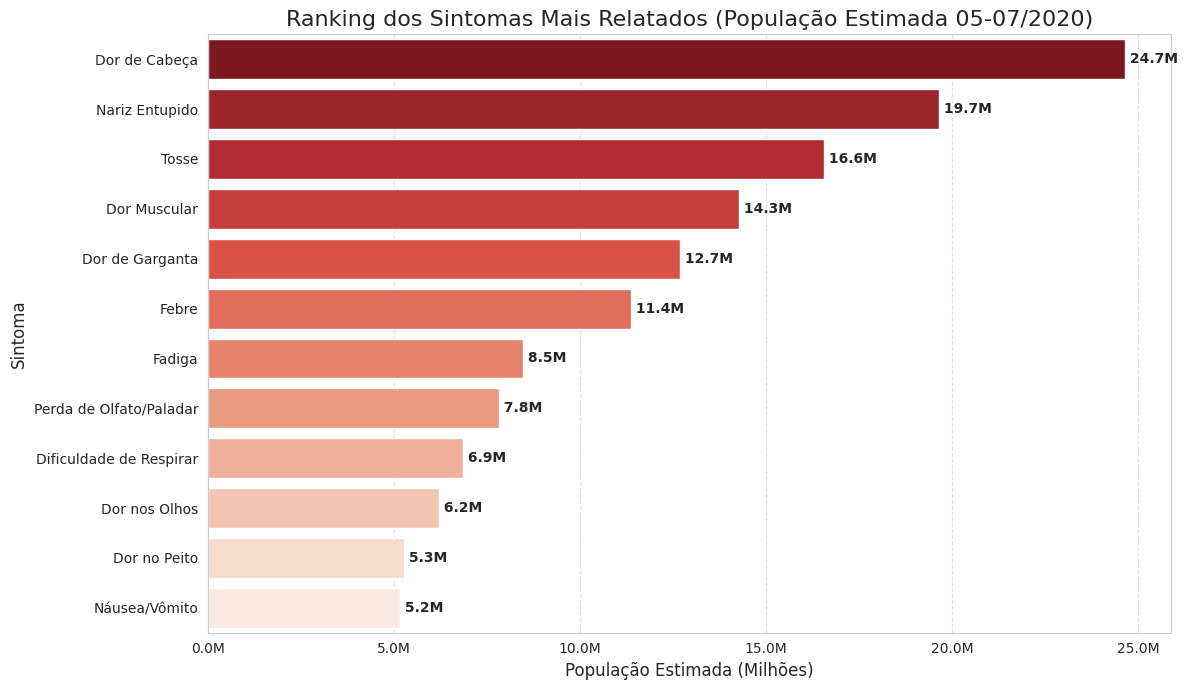

In [20]:
# CÉLULA: ANÁLISE DE SINTOMAS (BLOCO B)
from pyspark.sql.functions import sum, col, when, expr, desc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# 1. Lista de Códigos e Mapeamento (Baseado no Dicionário 05/2020)
sintomas_codes = [
    'B0011', 'B0012', 'B0013', 'B0014', 'B0015', 'B0016',
    'B0017', 'B0018', 'B0019', 'B00110', 'B00111', 'B00112'
]

map_sintomas = {
    'B0011': 'Febre',
    'B0012': 'Tosse',
    'B0013': 'Dor de Garganta',
    'B0014': 'Dificuldade de Respirar',
    'B0015': 'Dor de Cabeça',
    'B0016': 'Dor no Peito',
    'B0017': 'Náusea/Vômito',
    'B0018': 'Nariz Entupido',
    'B0019': 'Fadiga',
    'B00110': 'Dor nos Olhos',
    'B00111': 'Perda de Olfato/Paladar',
    'B00112': 'Dor Muscular'
}

# 2. AGREGAÇÃO OTIMIZADA (PySpark)
# Cria expressões para somar o peso (V1032) apenas se a resposta for 1 (Sim)
agg_exprs = [
    sum(when(col(c) == 1, col("V1032"))).alias(c)
    for c in sintomas_codes
]

# Executa a agregação em uma única passada
df_sintomas_wide = df_final.agg(*agg_exprs)

# Transforma de Colunas (Wide) para Linhas (Long) para facilitar o plot
stack_expr = ', '.join([f"'{c}', {c}" for c in sintomas_codes])
df_sintomas_long = df_sintomas_wide.select(
    expr(f"stack({len(sintomas_codes)}, {stack_expr}) as (Codigo, Populacao)")
)

# 3. PREPARAÇÃO PARA PLOTAGEM (Pandas)
df_sintomas_plot = df_sintomas_long.orderBy(desc("Populacao")).toPandas()
df_sintomas_plot['Descricao'] = df_sintomas_plot['Codigo'].map(map_sintomas)

# 4. PLOTAGEM DO GRÁFICO
plt.figure(figsize=(12, 7))
sns.barplot(
    x='Populacao',
    y='Descricao',
    data=df_sintomas_plot,
    palette='Reds_r' # Paleta vermelha (alerta)
)

# Formatação
def millions_formatter(x, pos):
    return f'{x/1e6:,.1f}M'

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
plt.title('Ranking dos Sintomas Mais Relatados (População Estimada 05-07/2020)', fontsize=16)
plt.xlabel('População Estimada (Milhões)', fontsize=12)
plt.ylabel('Sintoma', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Adicionar valores nas barras
for index, row in df_sintomas_plot.iterrows():
    plt.text(
        row['Populacao'],
        index,
        f" {row['Populacao']/1e6:.1f}M",
        va='center',
        fontsize=10,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

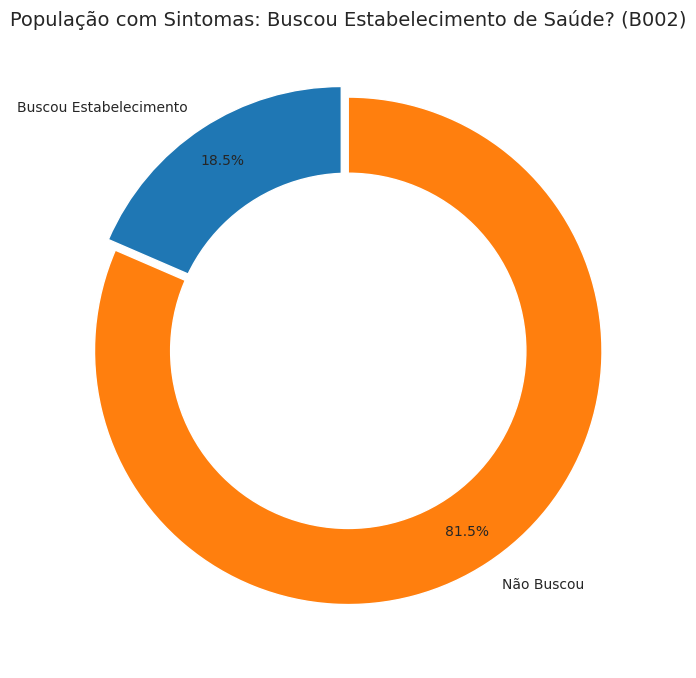

/tmp/ipython-input-257215272.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Populacao', y='Descricao', data=df_prov_plot, palette='Blues_r')


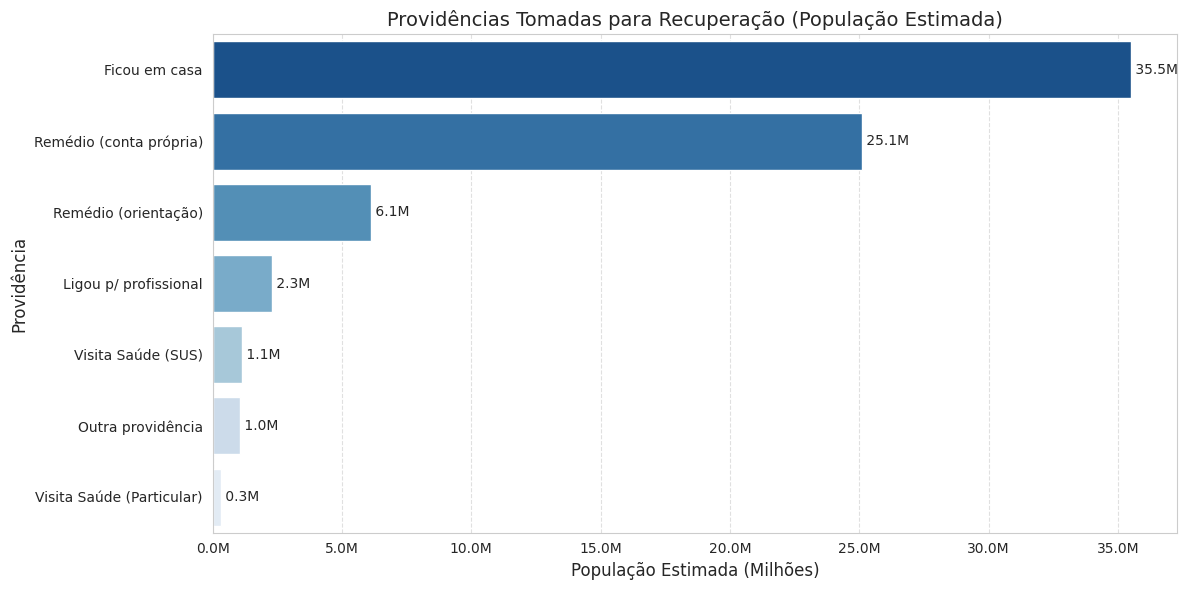

In [21]:
# CÉLULA: BUSCA POR SAÚDE E PROVIDÊNCIAS (BLOCO B)
from pyspark.sql.functions import sum, col, when, expr, desc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# === PARTE 1: BUSCA POR ESTABELECIMENTO DE SAÚDE (B002) ===
# Pergunta: "Por causa disso, foi a algum estabelecimento de saúde?"
# 1 = Sim, 2 = Não
df_busca = df_final.filter(col("B002").isin([1, 2])).groupBy("B002").agg(
    sum(col("V1032")).alias("Populacao")
).toPandas()

# Mapeamento e Cálculo
df_busca['Resposta'] = df_busca['B002'].map({1: 'Buscou Estabelecimento', 2: 'Não Buscou'})
total_sintomaticos = df_busca['Populacao'].sum()
df_busca['Porcentagem'] = (df_busca['Populacao'] / total_sintomaticos) * 100

# Plotagem (Gráfico de Pizza/Donut)
plt.figure(figsize=(7, 7))
plt.pie(df_busca['Populacao'], labels=df_busca['Resposta'], autopct='%1.1f%%',
        colors=['#1f77b4', '#ff7f0e'], startangle=90, pctdistance=0.85, explode=(0.05, 0))
# Círculo branco para transformar em Donut
centre_circle = plt.Circle((0,0),0.70,fc='white')
plt.gca().add_artist(centre_circle)
plt.title('População com Sintomas: Buscou Estabelecimento de Saúde? (B002)', fontsize=14)
plt.tight_layout()
plt.show()


# === PARTE 2: PROVIDÊNCIAS TOMADAS (B0031 a B0037) ===
# Pergunta: "Qual providência tomou para recuperar dos sintomas?"
# (Geralmente respondido por quem NÃO foi a estabelecimento ou como medida inicial)

providencias_codes = [
    'B0031', # Ficou em casa
    'B0032', # Ligou para profissional de saúde
    'B0033', # Tomou remédio por conta própria
    'B0034', # Tomou remédio sob orientação
    'B0035', # Recebeu visita (SUS)
    'B0036', # Recebeu visita (Particular)
    'B0037'  # Outra providência
]

map_providencias = {
    'B0031': 'Ficou em casa',
    'B0032': 'Ligou p/ profissional',
    'B0033': 'Remédio (conta própria)',
    'B0034': 'Remédio (orientação)',
    'B0035': 'Visita Saúde (SUS)',
    'B0036': 'Visita Saúde (Particular)',
    'B0037': 'Outra providência'
}

# Agregação (Conta apenas respostas "Sim" = 1)
agg_exprs_prov = [sum(when(col(c) == 1, col("V1032"))).alias(c) for c in providencias_codes]
df_prov_wide = df_final.agg(*agg_exprs_prov)

# Unpivot (Stack)
stack_str_prov = ', '.join([f"'{c}', {c}" for c in providencias_codes])
df_prov_long = df_prov_wide.select(
    expr(f"stack({len(providencias_codes)}, {stack_str_prov}) as (Codigo, Populacao)")
)

# Preparação Pandas
df_prov_plot = df_prov_long.orderBy(desc("Populacao")).toPandas()
df_prov_plot['Descricao'] = df_prov_plot['Codigo'].map(map_providencias)

# Plotagem (Barra Horizontal)
plt.figure(figsize=(12, 6))
sns.barplot(x='Populacao', y='Descricao', data=df_prov_plot, palette='Blues_r')

# Formatação
def millions_formatter(x, pos):
    return f'{x/1e6:,.1f}M'
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))

plt.title('Providências Tomadas para Recuperação (População Estimada)', fontsize=14)
plt.xlabel('População Estimada (Milhões)', fontsize=12)
plt.ylabel('Providência', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Valores nas barras
for index, row in df_prov_plot.iterrows():
    plt.text(row['Populacao'], index, f" {row['Populacao']/1e6:.1f}M", va='center', fontsize=10)

plt.tight_layout()
plt.show()

/tmp/ipython-input-1557958987.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Populacao', y='Descricao', data=df_locais_plot, palette='viridis')


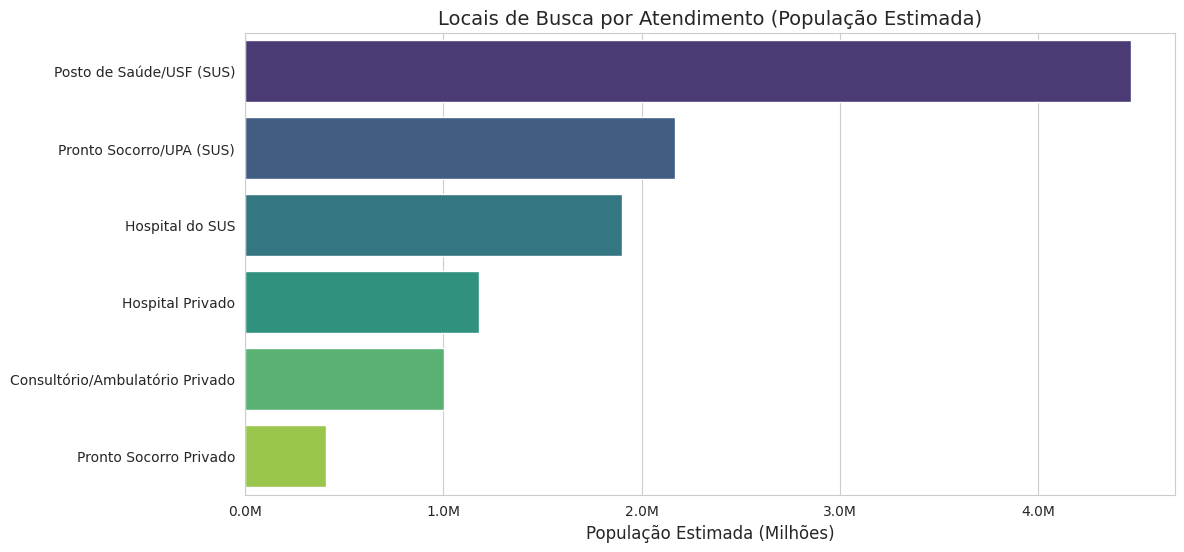

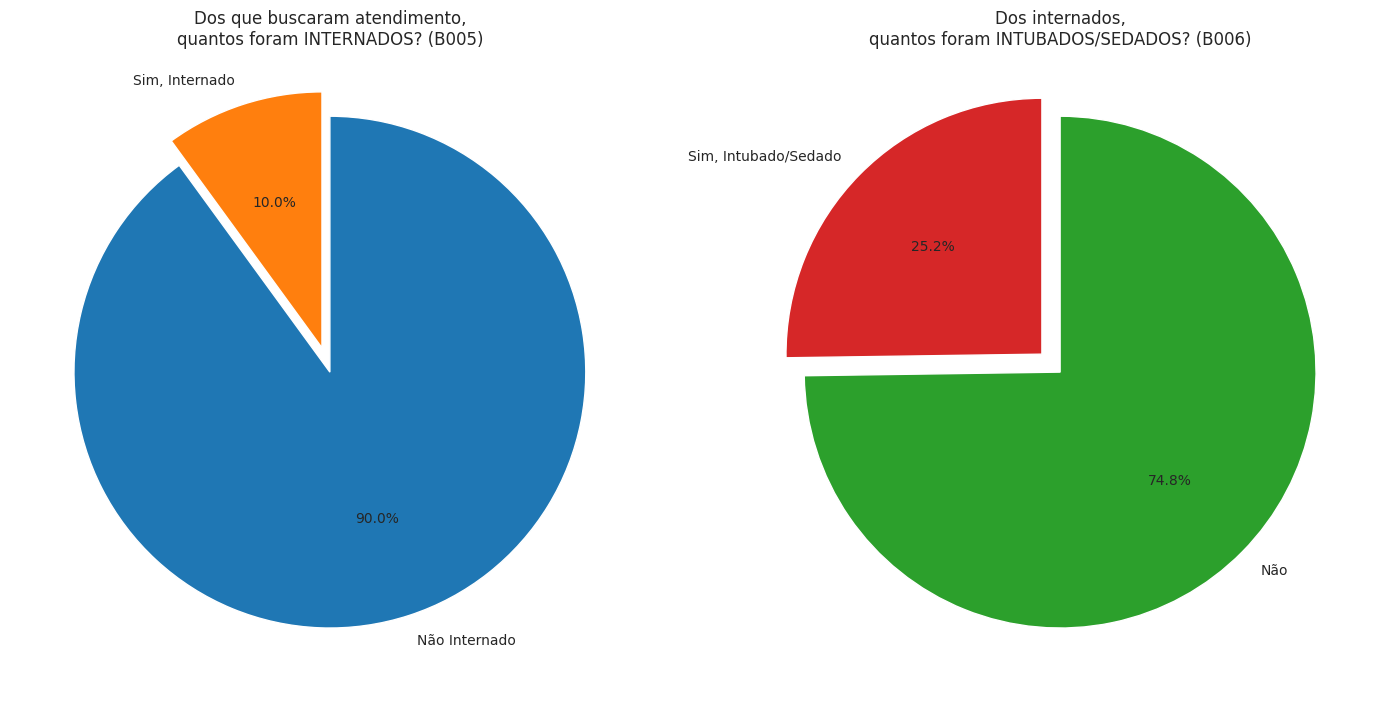

In [22]:
# CÉLULA: LOCAL DE ATENDIMENTO E GRAVIDADE (INTERNAÇÃO/INTUBAÇÃO)
from pyspark.sql.functions import sum, col, when, expr, desc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# === 1. LOCAIS DE ATENDIMENTO (B0041 a B0046) ===
# Pergunta: "Qual local buscou atendimento?" (Múltipla escolha: 1=Sim)

locais_codes = ['B0041', 'B0042', 'B0043', 'B0044', 'B0045', 'B0046']
map_locais = {
    'B0041': 'Posto de Saúde/USF (SUS)',
    'B0042': 'Pronto Socorro/UPA (SUS)',
    'B0043': 'Hospital do SUS',
    'B0044': 'Consultório/Ambulatório Privado',
    'B0045': 'Pronto Socorro Privado',
    'B0046': 'Hospital Privado'
}

# Agregação (Conta "Sim" = 1 para cada local)
agg_locais = [sum(when(col(c) == 1, col("V1032"))).alias(c) for c in locais_codes]
df_locais_wide = df_final.agg(*agg_locais)

# Unpivot
stack_str = ', '.join([f"'{c}', {c}" for c in locais_codes])
df_locais_long = df_locais_wide.select(
    expr(f"stack({len(locais_codes)}, {stack_str}) as (Codigo, Populacao)")
)
df_locais_plot = df_locais_long.orderBy(desc("Populacao")).toPandas()
df_locais_plot['Descricao'] = df_locais_plot['Codigo'].map(map_locais)

# Plotagem Locais
plt.figure(figsize=(12, 6))
sns.barplot(x='Populacao', y='Descricao', data=df_locais_plot, palette='viridis')
plt.title('Locais de Busca por Atendimento (População Estimada)', fontsize=14)
plt.xlabel('População Estimada (Milhões)', fontsize=12)
plt.ylabel('')
# Formatação Milhões
def millions_formatter(x, pos):
    return f'{x/1e6:,.1f}M'
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
plt.show()


# === 2. INTERNAÇÃO (B005) ===
# Pergunta: "Ficou internado por um dia ou mais?" (1=Sim, 2=Não)
df_internacao = df_final.filter(col("B005").isin([1, 2])).groupBy("B005").agg(
    sum(col("V1032")).alias("Populacao")
).toPandas()
df_internacao['Status'] = df_internacao['B005'].map({1: 'Sim, Internado', 2: 'Não Internado'})

# === 3. INTUBAÇÃO/SEDAÇÃO (B006) ===
# Pergunta: "Foi sedado, entubado ou colocado em respiração artificial?" (1=Sim, 2=Não)
# Filtra apenas quem foi internado (B005=1) para ter a base correta
df_intubacao = df_final.filter((col("B005") == 1) & (col("B006").isin([1, 2]))).groupBy("B006").agg(
    sum(col("V1032")).alias("Populacao")
).toPandas()
df_intubacao['Status'] = df_intubacao['B006'].map({1: 'Sim, Intubado/Sedado', 2: 'Não'})


# === PLOTAGEM COMBINADA (PIZZA) ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Gráfico Internação
ax1.pie(df_internacao['Populacao'], labels=df_internacao['Status'], autopct='%1.1f%%',
        colors=['#ff7f0e', '#1f77b4'], startangle=90, explode=(0.1, 0))
ax1.set_title('Dos que buscaram atendimento,\nquantos foram INTERNADOS? (B005)')

# Gráfico Intubação
# Se houver dados (evita erro se ninguém foi intubado na amostra)
if not df_intubacao.empty:
    ax2.pie(df_intubacao['Populacao'], labels=df_intubacao['Status'], autopct='%1.1f%%',
            colors=['#d62728', '#2ca02c'], startangle=90, explode=(0.1, 0))
    ax2.set_title('Dos internados,\nquantos foram INTUBADOS/SEDADOS? (B006)')
else:
    ax2.text(0.5, 0.5, 'Sem dados suficientes\npara Intubação', ha='center')

plt.tight_layout()
plt.show()

/tmp/ipython-input-2041953724.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Populacao', y='Motivo', data=df_motivo, palette='Oranges_r', ax=ax2)


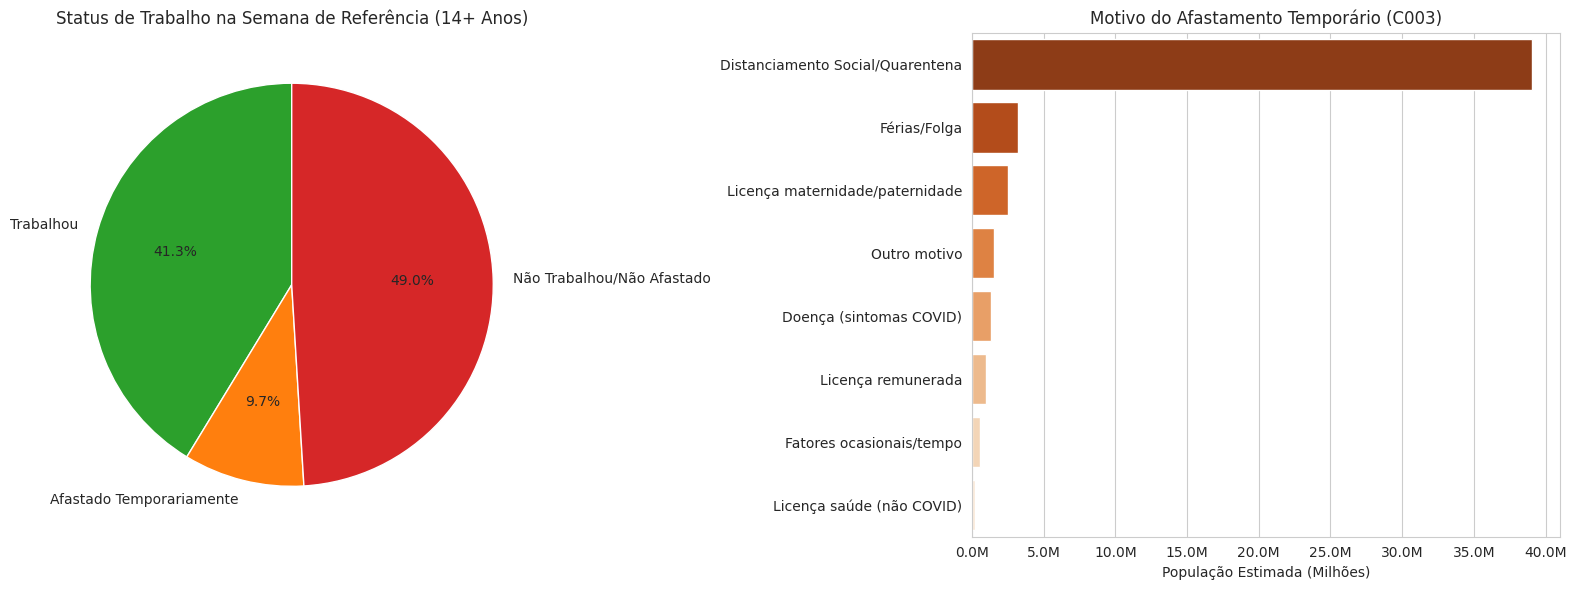

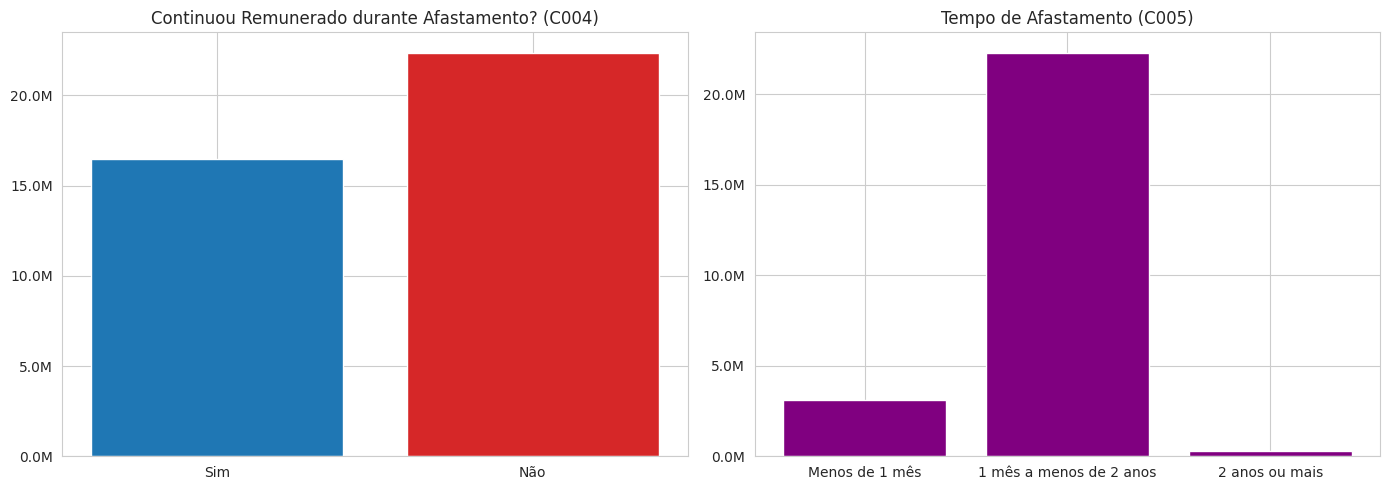

/tmp/ipython-input-2041953724.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Populacao', y='Vinculo', data=df_vinculo, palette='viridis', ax=ax2)


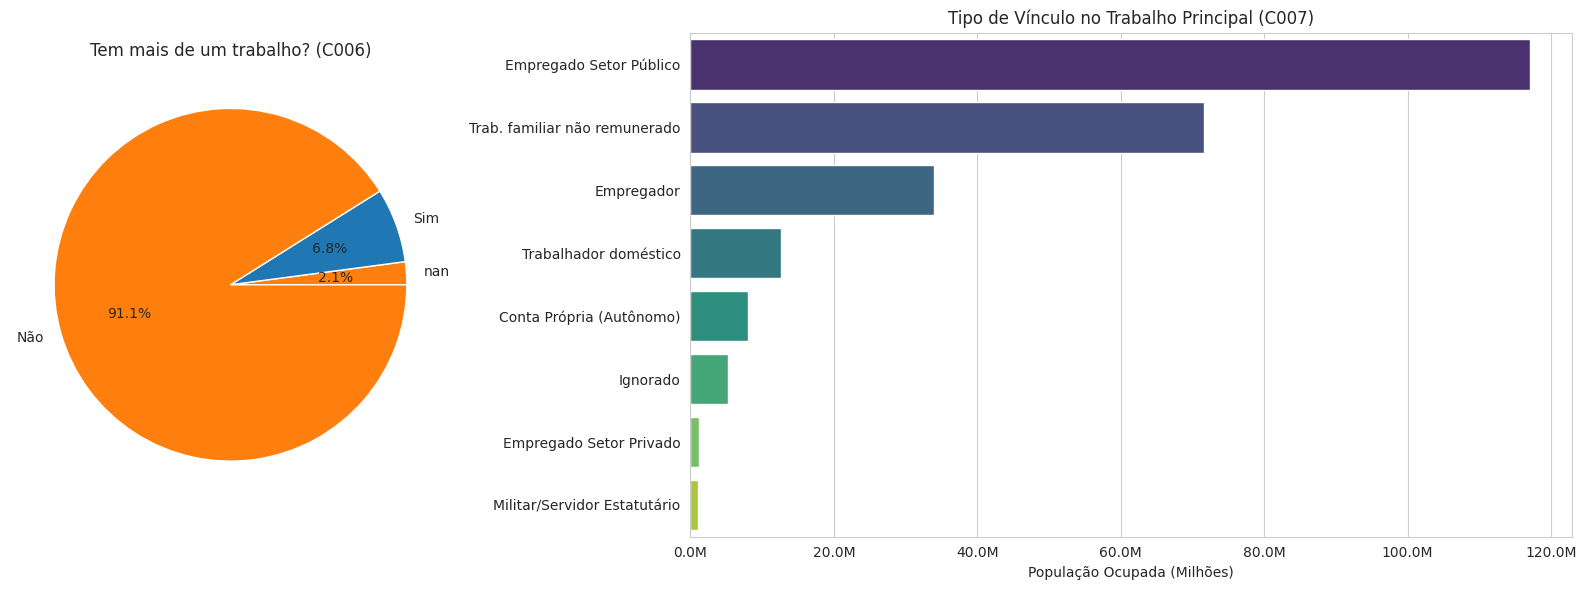

In [24]:
# CÉLULA: ANÁLISE DETALHADA DO MERCADO DE TRABALHO (PARTE C)
from pyspark.sql.functions import sum, col, when, desc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Configuração de Formatação
def millions_formatter(x, pos):
    return f'{x/1e6:,.1f}M'
formatter = ticker.FuncFormatter(millions_formatter)

# Filtro Base: Pessoas de 14 anos ou mais (População em Idade Ativa)
df_pia = df_final.filter(col("A002") >= 14)

# ==============================================================================
# 1. TRABALHO E AFASTAMENTO (C001, C002, C003)
# ==============================================================================

# C001: Trabalhou na semana passada?
# C002: Estava afastado temporariamente?
df_status_trab = df_pia.agg(
    sum(col("V1032")).alias("Total_PIA"),
    sum(when(col("C001") == 1, col("V1032"))).alias("Trabalhou"),
    sum(when(col("C002") == 1, col("V1032"))).alias("Afastado")
).toPandas()

# C003: Principal motivo do afastamento (Para quem C002 = 1)
map_motivo_afastamento = {
    1: 'Distanciamento Social/Quarentena', 2: 'Férias/Folga', 3: 'Licença remunerada',
    4: 'Licença maternidade/paternidade', 5: 'Licença saúde (não COVID)',
    6: 'Doença (sintomas COVID)', 7: 'Fatores ocasionais/tempo', 8: 'Outro motivo'
}

df_motivo = df_pia.filter(col("C002") == 1).groupBy("C003").agg(
    sum(col("V1032")).alias("Populacao")
).orderBy(desc("Populacao")).toPandas()
df_motivo['Motivo'] = df_motivo['C003'].map(map_motivo_afastamento)

# PLOTAGEM 1: Status e Motivo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de Pizza: Status da Força de Trabalho
labels_status = ['Trabalhou', 'Afastado Temporariamente', 'Não Trabalhou/Não Afastado']
sizes_status = [
    df_status_trab['Trabalhou'][0],
    df_status_trab['Afastado'][0],
    df_status_trab['Total_PIA'][0] - df_status_trab['Trabalhou'][0] - df_status_trab['Afastado'][0]
]
ax1.pie(sizes_status, labels=labels_status, autopct='%1.1f%%', colors=['#2ca02c', '#ff7f0e', '#d62728'], startangle=90)
ax1.set_title('Status de Trabalho na Semana de Referência (14+ Anos)')

# Gráfico de Barras: Motivo do Afastamento
sns.barplot(x='Populacao', y='Motivo', data=df_motivo, palette='Oranges_r', ax=ax2)
ax2.xaxis.set_major_formatter(formatter)
ax2.set_title('Motivo do Afastamento Temporário (C003)')
ax2.set_xlabel('População Estimada (Milhões)')
ax2.set_ylabel('')
plt.tight_layout()
plt.show()


# ==============================================================================
# 2. CONDIÇÕES DO AFASTAMENTO (C004, C005)
# ==============================================================================

# C004: Continuou sendo remunerado? (1=Sim, 2=Não)
# C005: Tempo de afastamento (1= <1 mês, 2= 1mês-1ano, 3= >1ano)
df_condicoes_afast = df_pia.filter(col("C002") == 1).agg(
    sum(when(col("C004") == 1, col("V1032"))).alias("Remunerado_Sim"),
    sum(when(col("C004") == 2, col("V1032"))).alias("Remunerado_Nao"),
    sum(when(col("C005") == 1, col("V1032"))).alias("Tempo_Menos_1Mes"),
    sum(when(col("C005") == 2, col("V1032"))).alias("Tempo_1Mes_a_1Ano"),
    sum(when(col("C005") == 3, col("V1032"))).alias("Tempo_Mais_1Ano")
).toPandas()

# PLOTAGEM 2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Remuneração
ax1.bar(['Sim', 'Não'], [df_condicoes_afast['Remunerado_Sim'][0], df_condicoes_afast['Remunerado_Nao'][0]], color=['#1f77b4', '#d62728'])
ax1.set_title('Continuou Remunerado durante Afastamento? (C004)')
ax1.yaxis.set_major_formatter(formatter)

# Tempo
tempos = ['Menos de 1 mês', '1 mês a menos de 2 anos', '2 anos ou mais'] # Ajuste conforme dicionário exato, C005 costuma ser faixas
vals_tempo = [df_condicoes_afast['Tempo_Menos_1Mes'][0], df_condicoes_afast['Tempo_1Mes_a_1Ano'][0], df_condicoes_afast['Tempo_Mais_1Ano'][0]]
ax2.bar(tempos, vals_tempo, color='purple')
ax2.set_title('Tempo de Afastamento (C005)')
ax2.yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()


# ==============================================================================
# 3. CARACTERÍSTICAS DO TRABALHO PRINCIPAL (C006, C007)
# ==============================================================================

# C006: Tem mais de um trabalho? (1=Sim, 2=Não)
# C007: Tipo de Vínculo/Posição no trabalho principal
map_vinculo = {
    1: 'Trabalhador doméstico', 2: 'Militar/Servidor Estatutário',
    3: 'Empregado Setor Privado', 4: 'Empregado Setor Público',
    5: 'Empregador', 6: 'Conta Própria (Autônomo)',
    7: 'Trab. familiar não remunerado', 9: 'Ignorado'
}

df_trab_atual = df_pia.filter((col("C001") == 1) | (col("C002") == 1)) # Quem tem trabalho

# Dados C006
df_multiplo = df_trab_atual.groupBy("C006").agg(sum(col("V1032")).alias("Populacao")).toPandas()
df_multiplo['Resposta'] = df_multiplo['C006'].map({1: 'Sim', 2: 'Não'})

# Dados C007
df_vinculo = df_trab_atual.groupBy("C007").agg(sum(col("V1032")).alias("Populacao")).orderBy(desc("Populacao")).toPandas()
df_vinculo['Vinculo'] = df_vinculo['C007'].map(map_vinculo)

# PLOTAGEM 3
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 2]})

# Múltiplos Trabalhos
ax1.pie(df_multiplo['Populacao'], labels=df_multiplo['Resposta'], autopct='%1.1f%%', colors=['#ff7f0e', '#1f77b4'])
ax1.set_title('Tem mais de um trabalho? (C006)')

# Tipo de Vínculo
sns.barplot(x='Populacao', y='Vinculo', data=df_vinculo, palette='viridis', ax=ax2)
ax2.xaxis.set_major_formatter(formatter)
ax2.set_title('Tipo de Vínculo no Trabalho Principal (C007)')
ax2.set_xlabel('População Ocupada (Milhões)')
ax2.set_ylabel('')
plt.tight_layout()
plt.show()




/tmp/ipython-input-1048530800.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Populacao', y='Faixa', data=df_faixa, palette='Greens_d')


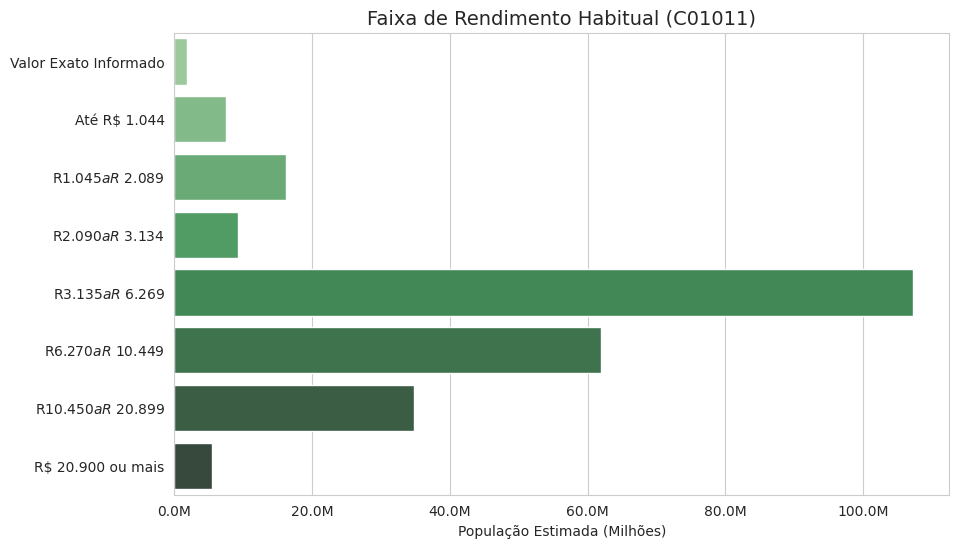

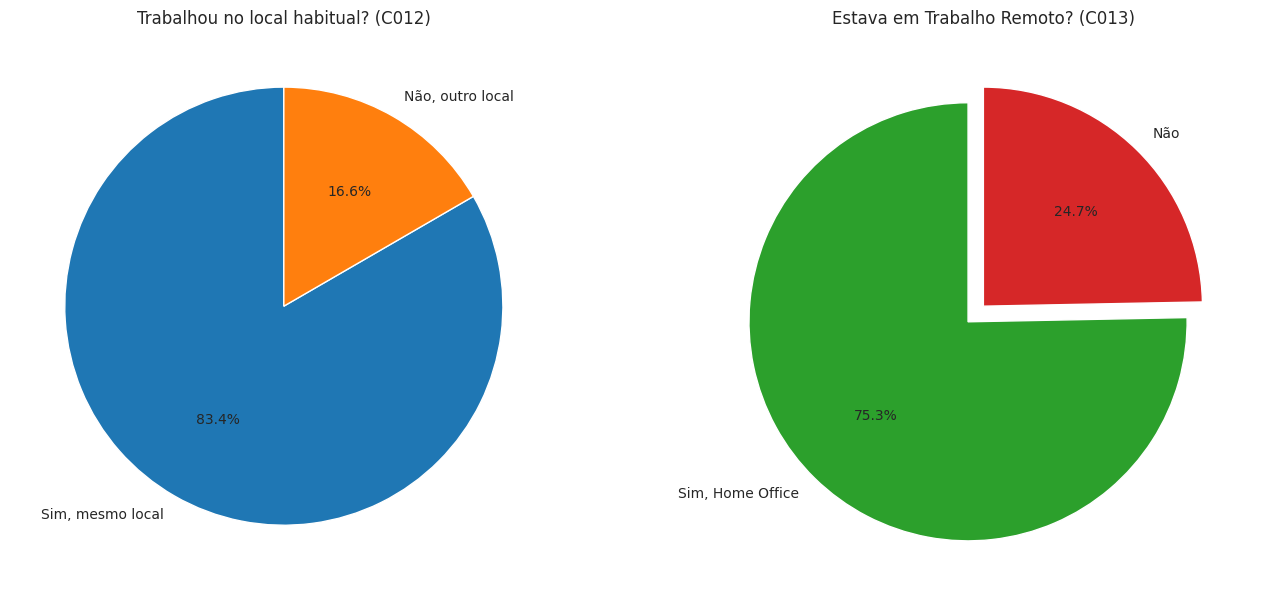

/tmp/ipython-input-1048530800.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Populacao', y='Motivo', data=df_motivo_np, palette='magma', ax=ax2)


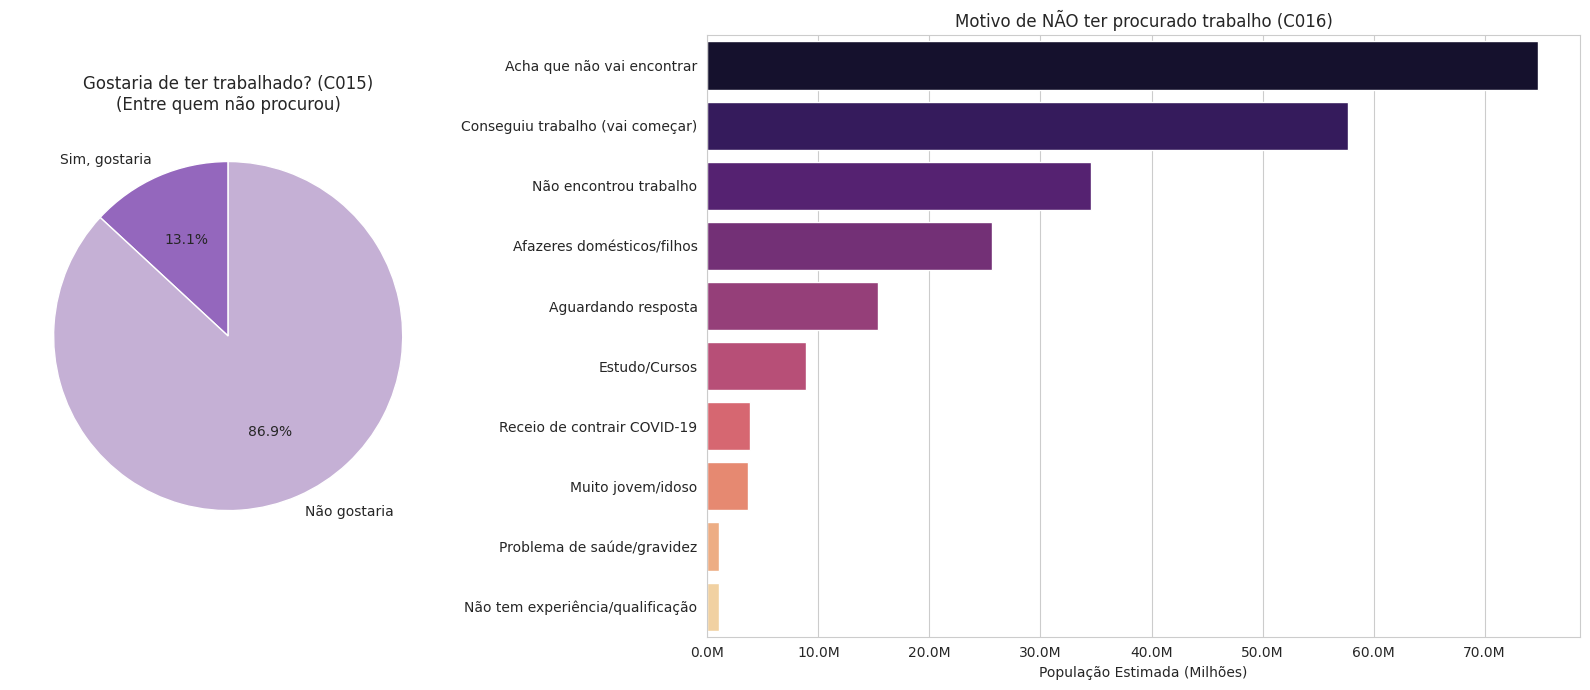

In [26]:
# CÉLULA: ANÁLISE ESPECÍFICA (RENDA, LOCAL, DESEJO DE TRABALHAR)
from pyspark.sql.functions import sum, col, desc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Formatação Milhões
def millions(x, pos): return f'{x/1e6:,.1f}M'
formatter = ticker.FuncFormatter(millions)

# Filtro: População em Idade Ativa (14+)
df_pia = df_final.filter(col("A002") >= 14)

# ==============================================================================
# 1. FAIXA DE RENDIMENTO (C01011)
# ==============================================================================
# "Número da faixa do rendimento/retirada em dinheiro"
# Códigos (Exemplo): 0=Informou Valor Exato, 1=Menos de 1 SM, etc.
# Ajuste o mapa conforme seu dicionário específico se necessário
map_faixa = {
    0: 'Valor Exato Informado',
    1: 'Até R$ 1.044',
    2: 'R$ 1.045 a R$ 2.089',
    3: 'R$ 2.090 a R$ 3.134',
    4: 'R$ 3.135 a R$ 6.269',
    5: 'R$ 6.270 a R$ 10.449',
    6: 'R$ 10.450 a R$ 20.899',
    7: 'R$ 20.900 ou mais'
}

df_faixa = df_pia.filter(col("C01011").isNotNull()).groupBy("C01011").agg(
    sum(col("V1032")).alias("Populacao")
).orderBy("C01011").toPandas()

df_faixa['Faixa'] = df_faixa['C01011'].map(map_faixa)

plt.figure(figsize=(10, 6))
sns.barplot(x='Populacao', y='Faixa', data=df_faixa, palette='Greens_d')
plt.gca().xaxis.set_major_formatter(formatter)
plt.title('Faixa de Rendimento Habitual (C01011)', fontsize=14)
plt.xlabel('População Estimada (Milhões)')
plt.ylabel('')
plt.show()


# ==============================================================================
# 2. LOCAL DE TRABALHO e REMOTO (C012, C013)
# ==============================================================================
# C012: "Trabalhou no mesmo local que costuma trabalhar?"
# C013: "Estava em trabalho remoto?"

# C012
df_local = df_pia.filter(col("C012").isin([1, 2])).groupBy("C012").agg(
    sum(col("V1032")).alias("Populacao")
).toPandas()
df_local['Resposta'] = df_local['C012'].map({1: 'Sim, mesmo local', 2: 'Não, outro local'})

# C013 (Apenas quem trabalhou C001=1)
df_remoto = df_pia.filter(col("C001") == 1).groupBy("C013").agg(
    sum(col("V1032")).alias("Populacao")
).toPandas()
df_remoto['Resposta'] = df_remoto['C013'].map({1: 'Sim, Home Office', 2: 'Não'})
df_remoto = df_remoto.dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico C012
ax1.pie(df_local['Populacao'], labels=df_local['Resposta'], autopct='%1.1f%%',
        colors=['#1f77b4', '#ff7f0e'], startangle=90)
ax1.set_title('Trabalhou no local habitual? (C012)')

# Gráfico C013
ax2.pie(df_remoto['Populacao'], labels=df_remoto['Resposta'], autopct='%1.1f%%',
        colors=['#2ca02c', '#d62728'], startangle=90, explode=(0.1, 0))
ax2.set_title('Estava em Trabalho Remoto? (C013)')

plt.tight_layout()
plt.show()


# ==============================================================================
# 3. DESEJO DE TRABALHAR e MOTIVO DE NÃO PROCURA (C015, C016)
# ==============================================================================
# C015: "Gostaria de ter trabalhado?" (Para quem não procurou)
# C016: "Principal motivo de não ter procurado?"

# C015
df_desejo = df_pia.filter(col("C015").isin([1, 2])).groupBy("C015").agg(
    sum(col("V1032")).alias("Populacao")
).toPandas()
df_desejo['Resposta'] = df_desejo['C015'].map({1: 'Sim, gostaria', 2: 'Não gostaria'})

# C016 - Motivos (Importante para ver o desalento/medo)
map_motivo_nao_procura = {
    1: 'Conseguiu trabalho (vai começar)',
    2: 'Aguardando resposta',
    3: 'Não encontrou trabalho',
    4: 'Acha que não vai encontrar',
    5: 'Não tem experiência/qualificação',
    6: 'Muito jovem/idoso',
    7: 'Estudo/Cursos',
    8: 'Afazeres domésticos/filhos',
    9: 'Problema de saúde/gravidez',
    10: 'Receio de contrair COVID-19', # <--- Motivo Pandemia!
    11: 'Não queria trabalhar',
    12: 'Outro motivo'
}

df_motivo_np = df_pia.filter(col("C016").isNotNull()).groupBy("C016").agg(
    sum(col("V1032")).alias("Populacao")
).orderBy(desc("Populacao")).toPandas()
df_motivo_np['Motivo'] = df_motivo_np['C016'].map(map_motivo_nao_procura)

# Plotagem
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), gridspec_kw={'width_ratios': [1, 2]})

# C015 Pizza
ax1.pie(df_desejo['Populacao'], labels=df_desejo['Resposta'], autopct='%1.1f%%',
        colors=['#9467bd', '#c5b0d5'], startangle=90)
ax1.set_title('Gostaria de ter trabalhado? (C015)\n(Entre quem não procurou)')

# C016 Barras (Motivo)
sns.barplot(x='Populacao', y='Motivo', data=df_motivo_np, palette='magma', ax=ax2)
ax2.xaxis.set_major_formatter(formatter)
ax2.set_title('Motivo de NÃO ter procurado trabalho (C016)')
ax2.set_xlabel('População Estimada (Milhões)')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

/tmp/ipython-input-919367418.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Beneficiarios', y='Fonte', data=df_plot, palette='viridis')


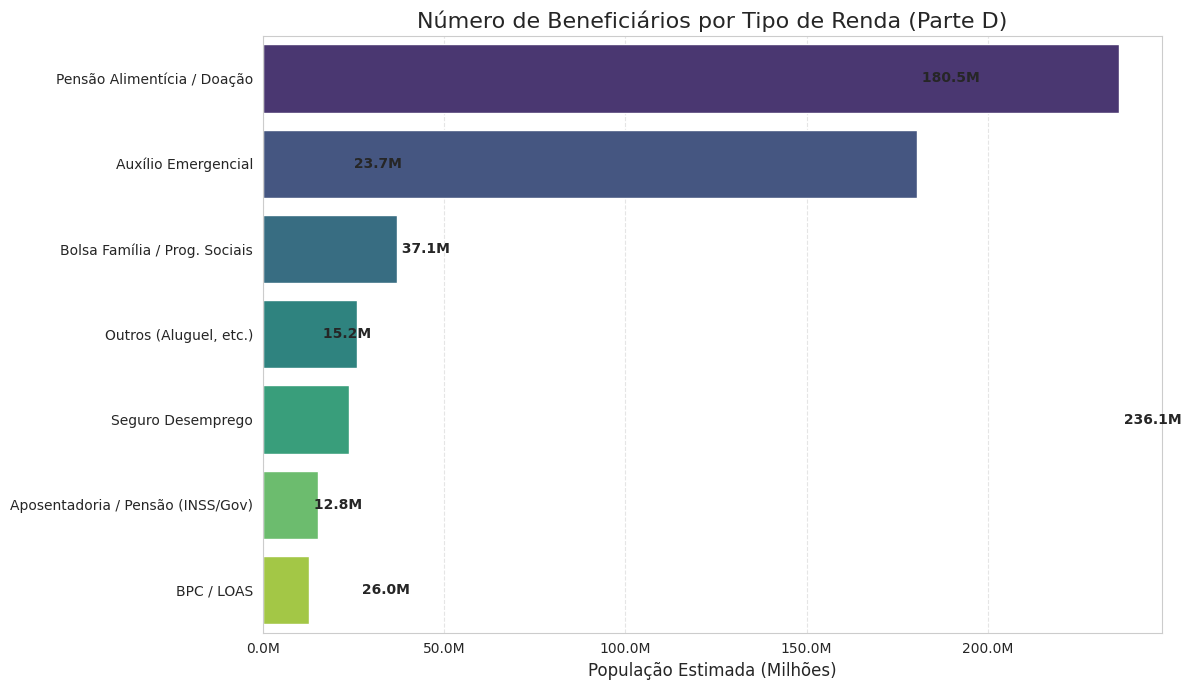

/tmp/ipython-input-919367418.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Valor_Medio', y='Fonte', data=df_plot_val, palette='Greens_r')


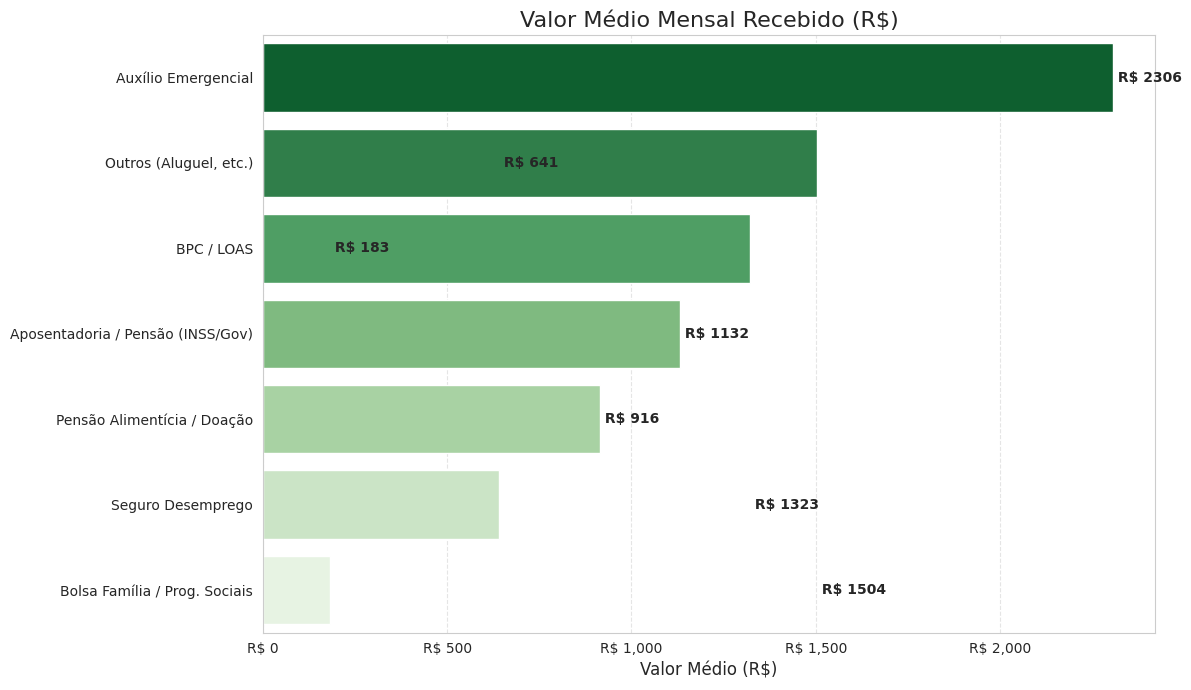

In [27]:
# CÉLULA: RENDIMENTOS DE OUTRAS FONTES (PARTE D)
from pyspark.sql.functions import sum, col, when, avg, desc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Configurações de Formatação
def millions_formatter(x, pos):
    return f'{x/1e6:,.1f}M'
def currency_formatter(x, pos):
    return f'R$ {x:,.0f}'

formatter_mil = ticker.FuncFormatter(millions_formatter)
formatter_real = ticker.FuncFormatter(currency_formatter)

# Filtro: População 14 anos ou mais
df_pia = df_final.filter(col("A002") >= 14)

# ==============================================================================
# 1. MAPEAMENTO DAS FONTES (D001 a D007)
# ==============================================================================
# O padrão é: D00x1 (Recebeu? 1=Sim) e D00x3 (Qual o valor?)

fontes_map = {
    'D0011': 'Auxílio Emergencial',
    'D0021': 'Seguro Desemprego',
    'D0031': 'Bolsa Família / Prog. Sociais',
    'D0041': 'Aposentadoria / Pensão (INSS/Gov)',
    'D0051': 'Pensão Alimentícia / Doação',
    'D0061': 'BPC / LOAS',
    'D0071': 'Outros (Aluguel, etc.)'
}

# ==============================================================================
# 2. AGREGAÇÃO (BENEFICIÁRIOS E VALORES)
# ==============================================================================

# Vamos criar uma lista de expressões para agregar tudo de uma vez
agg_exprs = []

for code_sim, desc_nome in fontes_map.items():
    # Coluna de Valor correspondente (Muda final 1 para 3. Ex: D0011 -> D0013)
    code_valor = code_sim[:-1] + '3'

    # 1. Quantidade de Beneficiários (Soma peso se Resposta=1)
    agg_exprs.append(sum(when(col(code_sim) == 1, col("V1032"))).alias(f"POP_{desc_nome}"))

    # 2. Valor Médio (Média do valor se Resposta=1)
    agg_exprs.append(avg(when(col(code_sim) == 1, col(code_valor))).alias(f"VAL_{desc_nome}"))

# Executa a agregação no Spark
df_renda_agg = df_pia.agg(*agg_exprs).toPandas()

# ==============================================================================
# 3. PREPARAÇÃO PARA PLOTAGEM (PANDAS)
# ==============================================================================

# Reorganizar o DataFrame de colunas para linhas (Tidy Format)
dados_plot = []
for code_sim, desc_nome in fontes_map.items():
    pop = df_renda_agg[f"POP_{desc_nome}"][0]
    val = df_renda_agg[f"VAL_{desc_nome}"][0]
    dados_plot.append({'Fonte': desc_nome, 'Beneficiarios': pop, 'Valor_Medio': val})

df_plot = pd.DataFrame(dados_plot).sort_values(by='Beneficiarios', ascending=False)

# ==============================================================================
# 4. PLOTAGEM GRÁFICO 1: NÚMERO DE BENEFICIÁRIOS
# ==============================================================================
plt.figure(figsize=(12, 7))
sns.barplot(x='Beneficiarios', y='Fonte', data=df_plot, palette='viridis')

plt.gca().xaxis.set_major_formatter(formatter_mil)
plt.title('Número de Beneficiários por Tipo de Renda (Parte D)', fontsize=16)
plt.xlabel('População Estimada (Milhões)', fontsize=12)
plt.ylabel('')
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Valores nas barras
for index, row in df_plot.iterrows():
    plt.text(row['Beneficiarios'], index, f" {row['Beneficiarios']/1e6:.1f}M", va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# ==============================================================================
# 5. PLOTAGEM GRÁFICO 2: VALOR MÉDIO RECEBIDO
# ==============================================================================
# Reordenar por valor para este gráfico
df_plot_val = df_plot.sort_values(by='Valor_Medio', ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x='Valor_Medio', y='Fonte', data=df_plot_val, palette='Greens_r')

plt.gca().xaxis.set_major_formatter(formatter_real)
plt.title('Valor Médio Mensal Recebido (R$)', fontsize=16)
plt.xlabel('Valor Médio (R$)', fontsize=12)
plt.ylabel('')
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Valores nas barras
for index, row in df_plot_val.iterrows():
    plt.text(row['Valor_Medio'], index, f" R$ {row['Valor_Medio']:.0f}", va='center', fontweight='bold')

plt.tight_layout()
plt.show()